https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

### Errors
- not masking the pad inputs for backprop
`

# Things you're trying and may need to change back
- batchnorm eval on cnn during training
- tanh non-linearity when projecting cnn output to embedding space
- using cnn output as first input to rnn instead of as hidden state -- what about SOS?
- Train embeddings or don't use w2v?

In [1]:
import torch
import re, pickle, collections, numpy as np, keras, math, operator, pdb
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.autograd import Variable
from torch import optim
from torchvision.models import inception_v3
import torch.nn.functional as F
from keras.preprocessing.sequence import pad_sequences
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import re
from os import path
from glob import glob
from torch.utils.data import DataLoader
from PIL import Image
from data_loader import get_loader
from build_vocab import build_vocab
from encoder import Encoder
from torch.nn.utils.rnn import pack_padded_sequence
from utils import *
from create_emb_matrix import create_emb_mat
from decoder import LSTMDecoder
import pdb
%load_ext autoreload
%autoreload 2


Using TensorFlow backend.


In [2]:
- You have tuples of image names and captions. 
- Pass those into your custom dataset. Along with your transform, vocab and root directory.
- implement the getitem function that loads and transforms the image. And also tokenizes and encodes the caption.
- then write your collate function.
- and get_loader function.

SyntaxError: invalid syntax (<ipython-input-2-988a52345229>, line 1)

In [24]:
dpath = '/data/image_captioning/flikr8/'
#'/data/image_captioning/flikr8/Flicker8k_Dataset/train/wrap/'
imgpath =  '/data/image_captioning/flikr8/Flicker8k_Dataset/' 
tr_img_path = imgpath +'train/'
samp_tr_img_path = imgpath + 'samp/train/wrap/'

In [16]:
tr_caps = pickle.load(open(dpath+'train_first_caps.pkl', 'rb'))

In [25]:
samp_caps = make_samp_caps(tr_caps, samp_tr_img_path+'*.jpg'); len(samp_caps)

32

In [26]:
vocab = build_vocab(tr_caps, 0)

[0/6000] Tokenized the captions.
[1000/6000] Tokenized the captions.
[2000/6000] Tokenized the captions.
[3000/6000] Tokenized the captions.
[4000/6000] Tokenized the captions.
[5000/6000] Tokenized the captions.


In [5]:
embed_path = '/data/word_embed/glove.6B.300d.txt'
embs, found = create_emb_mat(vocab, embed_path=embed_path); embs.shape, found

((3894, 300), 3703)

In [20]:
dl = get_loader(samp_tr_img_path, samp_caps, vocab, batch_size=4, shuffle=True, num_workers=1)

In [27]:
enc = Encoder(batch_size=4, emb_size=300, pool_size=8, fc_in_size=2048)
dec = LSTMDecoder(len(vocab), 300, 2)

LR = 0.001
params = list(dec.parameters()) + list(enc.linear.parameters()) + list(enc.bn.parameters())
optimizer = torch.optim.Adam(params, lr=LR)


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/torchvision-0.1.9-py3.6.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.


In [32]:
crit = nn.CrossEntropyLoss()

while True:
    dl = get_loader(samp_tr_img_path, samp_caps, vocab, batch_size=4, shuffle=True, num_workers=1)
    tot_loss = 0.0
    for i, (imgs, caps, ls) in enumerate(dl):
        
        optimizer.zero_grad()
        #dl.dataset.sanity(imgs, caps, ls)
        #pdb.set_trace()
        imgs = to_var(imgs); caps = to_var(caps) #VOLATILE ON IMGS MAYBE?
        targets = pack_padded_sequence(caps, ls, batch_first=True)[0]
        imgs_enc = enc(imgs)

        out = dec(imgs_enc, caps, ls)
        loss = crit(out, targets)
        loss.backward()
        tot_loss += loss
        optimizer.step()
        
    print(tot_loss.data[0] / i)
    

2.652873992919922
2.519579751150949
2.426385062081473
2.3247571672712053
2.2135957990373885
2.1005400248936246
2.025571278163365
1.9147306169782365
1.8251673834664481
1.732748576572963
1.6361231122698103
1.546114240373884
1.4740279061453683
1.3930967875889368
1.3239702497209822
1.2541862215314592
1.176802498953683
1.1172451972961426
1.0559123584202357
0.9910214969090053
0.9384397097996303
0.8905506134033203
0.8428895132882255
0.7989612306867327
0.7620825086321149
0.7291935511997768
0.6983633041381836
0.6678266525268555
0.6316217013767788
0.6075169699532645
0.5847842352730888
0.5670104026794434
0.5371909822736468
0.525493962424142
0.4982339654650007
0.4843665191105434
0.4689692769731794
0.4572088377816336
0.4337646280016218
0.42345435278756277
0.40624468667166574
0.39680732999529156
0.3904514993940081
0.38393875530787874
0.3588033744267055
0.35654514176504953
0.34636592864990234
0.3511103902544294
0.3284380095345633
0.3283287457057408
0.3195763996669224
0.3077826840536935
0.303554024015

Process Process-152:
Traceback (most recent call last):
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _rec

KeyboardInterrupt: 

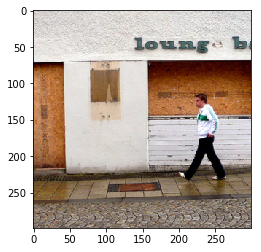

<start> a man in a long sleeved white shirt is walking past something called the lounge bar . <end> <end>


In [50]:
dl = get_loader(samp_tr_img_path, samp_caps, vocab, batch_size=4, shuffle=True, num_workers=1)
    
for i, (imgs, caps, ls) in enumerate(dl):
    
    #dl.dataset.sanity(imgs, caps, ls)
    imgs = to_var(imgs); caps = to_var(caps) #VOLATILE ON IMGS MAYBE?
    #targets = pack_padded_sequence(caps, ls, batch_first=True)[0]
    enc.eval()
    imgs_enc = enc(imgs)
    enc.train()
    samples = dec.sample(imgs_enc)
    
    break
plt.imshow(revTrans(imgs[0, :, :, :].data))
plt.show()
print(vocab.turnId2W(samples.data[0].numpy()))

'<start> a man in a long sleeved white shirt is walking past something called the lounge bar . <end> <end>'

In [ ]:
ix = np.random.randint

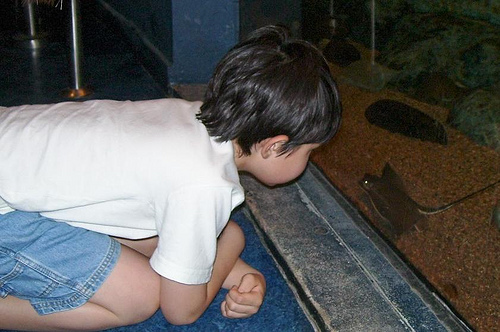

In [22]:
Image.open('/data/image_captioning/flikr8/Flicker8k_Dataset/train/wrap/2622517932_57c52c376f.jpg')

In [8]:
from torchvision.models import inception_v3
cnn = inception_v3(pretrained=True)

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/torchvision-0.1.9-py3.6.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
